# Move to the directory

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd ./drive/My\ Drive/perso/Emotion_recognition_over_txt

# Import all the library

In [0]:
import torch
import torch.nn as nn
from torchtext import data
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
import csv

import random

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline

# Fetch and visualize data

convert data in CSV file

In [0]:
with open('emotion.csv', 'w') as f1:
    writer = csv.writer(f1)
    writer.writerow(["id", "x", "y"]) #headers
    with open("./emotion.data", "r", newline='') as f2:
      for s in f2:
        sentence = s.split(",")
        writer.writerow([sentence[0], sentence[1], sentence[2]])

In [0]:
X_prepocessing = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
Y_prepocessing = data.LabelField(dtype = torch.float,batch_first=True)

fields = [(None, None), ('x',X_prepocessing),('y', Y_prepocessing)]

#loading custom dataset
all_data = data.TabularDataset(path = 'emotion.csv',format = 'csv',fields = fields,skip_header = True)
all_data.examples = all_data.examples[1::]

In [0]:
#print preprocessed text
train_data, test_data, val_data = all_data.split(split_ratio=[0.90, 0.02, 0.08], random_state = random.seed(31))

In [8]:
print("Training set size {}".format(len(train_data)))
print("Test set size {}".format(len(test_data)))
print("Validation set size {}".format(len(val_data)))

Training set size 375128
Test set size 33345
Validation set size 8336


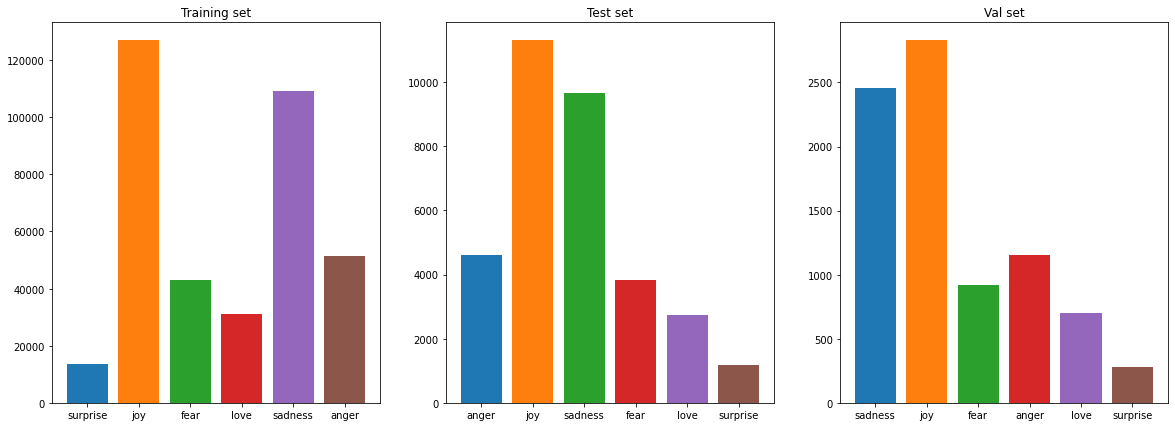

In [9]:
train_data_spread = {}
for d in train_data : 
  if d.y in train_data_spread:
    train_data_spread[d.y] += 1
  else:
    train_data_spread[d.y] = 1

test_data_spread = {}
for d in test_data : 
  if d.y in test_data_spread:
    test_data_spread[d.y] += 1
  else:
    test_data_spread[d.y] = 1

val_data_spread = {}
for d in val_data : 
  if d.y in val_data_spread:
    val_data_spread[d.y] += 1
  else:
    val_data_spread[d.y] = 1


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
axes[0].set_title('Training set')
for item in train_data_spread.keys():
  axes[0].bar(item, train_data_spread[item])
axes[1].set_title('Test set')
for item in test_data_spread.keys():
  axes[1].bar(item, test_data_spread[item])
axes[2].set_title('Val set')
for item in val_data_spread.keys():
  axes[2].bar(item, val_data_spread[item])


We can see that our dataset is not balanced at all.

Build the vocabulary

In [0]:
#initialize glove embeddings
X_prepocessing.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d") # using pretrained embedding
Y_prepocessing.build_vocab(train_data)
#No. of unique tokens in text
print("Size of X_prepocessing vocabulary:",len(X_prepocessing.vocab))
#No. of unique tokens in label
print("Size of Y_prepocessing vocabulary:",len(Y_prepocessing.vocab))
#Commonly used words
print(X_prepocessing.vocab.freqs.most_common(10))  
#Word dictionary
print(X_prepocessing.vocab.stoi)   #string to identifier

In [11]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print("Using {}".format(device))

Using cuda


In [0]:
#set batch size
BATCH_SIZE = 64

#Load an iterator for train, test, val
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

val_iterator = data.BucketIterator(
    val_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

# Defining model

In [0]:
class Net(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx, bidirectional=True):
    super(Net, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

    self.lstm = nn.LSTM(emb_dim, hidden_state, nb_layers, batch_first=True, bidirectional=True)
    
    self.fc1 = nn.Linear(hidden_state * 2, nb_class)
    
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.emb(x)

    output, (h_n, c_n) = self.lstm(x)

    h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)
    
    x = self.fc1(h_n)

    return self.softmax(x) #output ==> (BS, max_nb_word, nb_class)

# Train model

In [0]:
MODELS_DIR = "models"
MODEL_NAME = "best_model.pth"
def save_model(model, directory=MODELS_DIR, model_name=MODEL_NAME):
  if not os.path.exists(directory):
      os.makedirs(directory)
  if ".pth" not in model_name:
    model_name += ".pth"
  print("Saving model")
  torch.save(model.state_dict(), os.path.join(directory, model_name))

In [15]:
#GLOBAL PARAM
LOSS = 'loss'
EVAL_PRECISION = 'eval_precision'

#Training parameters
num_epochs = 50
early_stopping_rate = 5
patience = early_stopping_rate
early_stopping_param = LOSS # loss || eval_precision
lr_decay_patience = 2
assert early_stopping_param == LOSS or early_stopping_param == EVAL_PRECISION, "early stopping parameter is not correct, you have to chose it between loss or eval_precision"

#Neural net parameters
vocab_size = len(X_prepocessing.vocab)
nb_class = len(Y_prepocessing.vocab)
emb_dim = 200
hidden_state = 320
nb_layers = 1
bidirectional = True
padding_idx = X_prepocessing.vocab.stoi['<pad>'] #get the index of padding in the vocabulary

model = Net(vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx,bidirectional).to(device)
print(model)

Net(
  (emb): Embedding(28992, 200, padding_idx=1)
  (lstm): LSTM(200, 320, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=640, out_features=6, bias=True)
  (softmax): Softmax(dim=-1)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#learning rate optimizer ==> https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min' if early_stopping_param == LOSS else 'max', patience=lr_decay_patience, verbose=True) 

best_early_stopping_param = 0 if early_stopping_param == EVAL_PRECISION else float("inf")

print("Start training :")
for epoch in range(50):
  model.train()
  epoch_loss = 0
  batch_loss = 0
  print("Starting epoch", epoch+1)
  for i, ((data, labels), _) in enumerate(train_iterator):
    X = data[0].to(device)
    y = labels.to(device)
    txt_lengths = data[1].to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    preds = model(X).float()
    loss = criterion(preds, y.long())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    batch_loss = round(loss.item(), 2)

    if i % 1000 == 0: #every 1000 batch
      print("loss of the {}'th batch : {}".format(i, batch_loss))
  epoch_loss = round(epoch_loss, 2)
  print("Epoch {}'th loss: {}".format(epoch+1, epoch_loss))
  print()
  print("Evaluation ...")
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    precision = 0
    for (data, labels), _ in val_iterator:
      X = data[0].to(device)
      y = labels.to(device)
      
      outputs = model(X).float()
      _, predicted = torch.max(outputs.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

    precision = round((100 * correct / total), 2)
    print('Precision on the validation set: {}'.format(precision))
  print()
  #early_stopping
  if early_stopping_param == LOSS:
    if epoch_loss < best_early_stopping_param:
      best_early_stopping_param = epoch_loss
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  elif early_stopping_param == EVAL_PRECISION:
    if precision > best_early_stopping_param:
      best_early_stopping_aram = precision
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  

  print("Early stopping patience : {}".format(patience))

  if patience == 0:
    print("Training stopped due to early stopping.")
    break

  # Note that step should be called after validate()
  scheduler.step(best_early_stopping_param)
  print()


Start training :
Starting epoch 1
loss of the 0'th batch : 1.8
loss of the 1000'th batch : 1.68
loss of the 2000'th batch : 1.67
loss of the 3000'th batch : 1.62
loss of the 4000'th batch : 1.61
loss of the 5000'th batch : 1.63
Epoch 1'th loss: 9722.27

Evaluation ...
Precision on the validation set: 42.31

Saving model
Early stopping patience : 5

Starting epoch 2
loss of the 0'th batch : 1.73
loss of the 1000'th batch : 1.57
loss of the 2000'th batch : 1.62
loss of the 3000'th batch : 1.57
loss of the 4000'th batch : 1.5
loss of the 5000'th batch : 1.49
Epoch 2'th loss: 9123.4

Evaluation ...
Precision on the validation set: 57.33

Saving model
Early stopping patience : 5

Starting epoch 3
loss of the 0'th batch : 1.48
loss of the 1000'th batch : 1.42
loss of the 2000'th batch : 1.56
loss of the 3000'th batch : 1.41
loss of the 4000'th batch : 1.42
loss of the 5000'th batch : 1.51
Epoch 3'th loss: 8592.93

Evaluation ...
Precision on the validation set: 57.74

Saving model
Early stop

# Test model

In [17]:
model = Net(vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx,bidirectional).to(device)
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, MODEL_NAME)))

<All keys matched successfully>

In [18]:
all_preds = torch.tensor([], dtype=torch.long).to(device) #used for ploting results
all_gt = torch.tensor([], dtype=torch.long).to(device) #used for plotting results
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for (data, labels), _ in test_iterator:
      X = data[0].to(device)
      y = labels.to(device).long()
      outputs = model(X)
      _, predicted = torch.max(outputs.data, 1)
      predicted = predicted.long()
      all_preds = torch.cat(
              (all_preds, predicted)
              ,dim=0
          )
      all_gt = torch.cat(
              (all_gt, y)
              ,dim=0
          )
      total += y.size(0)
      correct += (predicted == y).sum().item()
    
precision = round((100 * correct / total), 2)
print('Precision on the test set: {}'.format(precision))

Precision on the test set: 91.58


In [0]:
#this code is taken from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

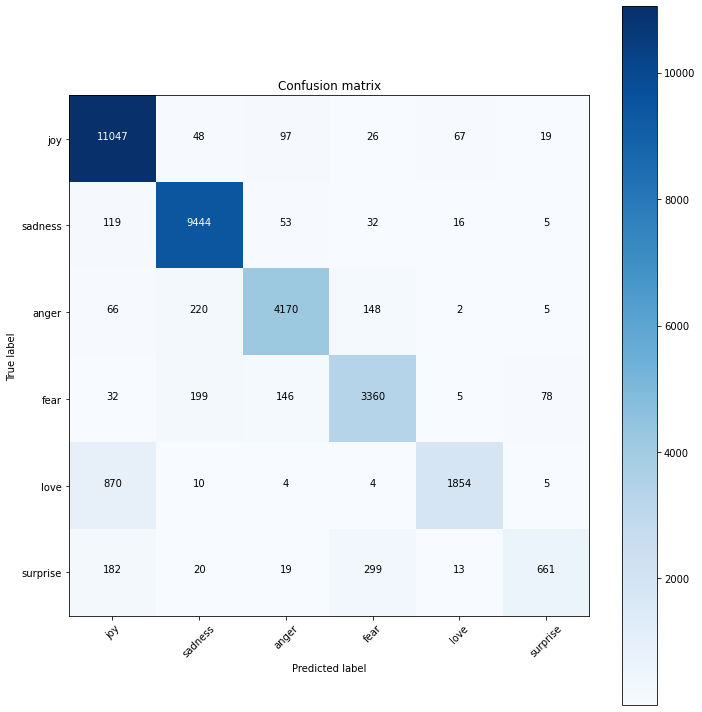

In [20]:
cm = confusion_matrix(all_gt.cpu(), all_preds.cpu())
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, Y_prepocessing.vocab.itos)

In [0]:
def get_emotion(model, sentence):
  """
  function that return the emotion of the sentence given in the parameter by the order of the weights
  Args:
    - model : model to use to predict
    - sentence : sentence to predict its emotion
  return:
    - list of the emotion ordered by their weights
    - list of the weights
  """
  X = torch.Tensor([[X_prepocessing.vocab.stoi[word] for word in sentence.split(" ")]]).to(device).long()
  preds = model(X)
  result = torch.argmax(preds, dim=-1)
  return [Y_prepocessing.vocab.itos[p.item()] for p in preds[0].argsort(dim=-1, descending=True)], preds

In [22]:
print(get_emotion(model, "i was happy but now i am furious"))

(['anger', 'joy', 'surprise', 'fear', 'love', 'sadness'], tensor([[3.9369e-02, 1.5635e-09, 9.6055e-01, 3.8356e-07, 3.6099e-08, 8.4777e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>))
